## This is a Python analysis of RideAustin's daily ride requests, identifying a weekly cycle in requests, and using that cycle to predict weekly growth using an exponential curve fit

Data was made available by CEO Andy Tryba, at https://data.world/andytryba/rideaustin

Ride Austin is a nonprofit, municipal ridesharing service based in Austin, Texas, with a model comparing directly to that of Uber. The data released covers rides requested from June 16 to August 31, just over 11 weeks. It shows a clear cycle weekly, typically with peak ride demand on Saturday. 

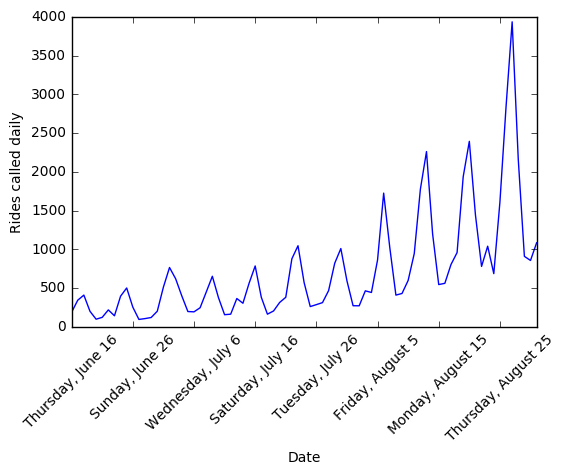

In [45]:
#loading the dataset
from pandas import Series
from matplotlib import pyplot
RideVolume = Series.from_csv('RideVolume.csv', header=0)
RideVolume.plot()
pyplot.xticks(rotation=45)
pyplot.ylabel('Rides called daily')
pyplot.show()
pyplot.close()

Plainly, the plot shows a regular weekly spike; count and you see 11 spikes, corresponding to the 11+ weeks in the data set. We also see a dramatic growth in this time, a 10-fold expansion from the first to the last Saturday in the series. Though it's less obvious, the less popular days (Monday and Tuesday) also show a roughly 10x expansion across this time. 

Intuitively, the set of points looks much like a exponential growth, with some additional fluctuations in it. To model this as a curve-fit directly from the data points will be difficult, because there is a large difference between the days of the week. So, I'm going to separate the data points available into the different specific days of the week, and perform an exponential growth curve fit on these series.

This code is adapted in part from Leandro's answer, here:
http://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly

In [2]:
# Separating the CSV into a series for each weekday. Because the number of entries 
# is small, it makes sense to do this by hand-entering integer location values.
# However, these values can be generated automatically for any range, easily.
Mondays=series.iloc[[4,11,18,25,32,39,46,53,60,67,74]]
Tuesdays=series.iloc[[5,12,19,26,33,40,47,54,61,68,75]]
Wednesdays=series.iloc[[6,13,20,27,34,41,48,55,62,69,76]]
Thursdays=series.iloc[[0,7,14,21,28,35,42,49,56,63,70]]
Fridays=series.iloc[[1,8,15,22,29,36,43,50,57,64,71]]
Saturdays=series.iloc[[2,9,16,23,30,37,44,51,58,65,72]]
Sundays=series.iloc[[3,10,17,24,31,38,45,52,59,66,73]]
print(Saturdays)

Date
Saturday, June 18       411
Saturday, June 25       503
Saturday, July 2        767
Saturday, July 9        654
Saturday, July 16       787
Saturday, July 23      1048
Saturday, July 30      1012
Saturday, August 6     1727
Saturday, August 13    2263
Saturday, August 20    2395
Saturday, August 27    3937
Name: Rides, dtype: int64


In [63]:
#Now we can find a curve which fits to the Saturdays specifically
#Adapted from http://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy
import sympy

# We can model it using the curve-fit for the data presented as weekly events, which we'll call 'weekly'
# below, but in order to superimpose the function onto the plot we'll need to be able to graph the 
# resulting curve against the days, so we can use both.
weekly=numpy.array([1,2,3,4,5,6,7,8,9,10,11], dtype=float)
daily=numpy.array([2,9,16,23,30,37,44,51,58,65,72], dtype=float)
SaturdayArray=numpy.array(Saturdays[:], dtype=float)
# by taking 1:11 as the values for X, we're treating each Saturday as a new week.


# Below is an exponential function with unknown coefficient and unknown y-intercept
def func(x, a, b):
    return b + a**x 
# we're going to use scipy's curve_fit to optimize for it
#this may throw a libMKL error unless you're using numpy 11.1.13+
poptweek, pcovweek = curve_fit(func,weekly,SaturdayArray) # x is the 'week' array, y is '
print(poptweek) 
print(pcovweek)

[   2.08648397  840.03616089]
[[  4.48101711e-04  -1.23305279e+00]
 [ -1.23305279e+00   1.48595869e+04]]


The first list is the optimized parameters for A and B, considered weekly. We can also get them considered daily, which we want to do in order to overlay the plot on our data from above.

In [81]:
poptday, pcovday = curve_fit(func,daily,SaturdayArray) 
print(poptday)
#print(pcovday)

[   1.11885051  867.18954071]


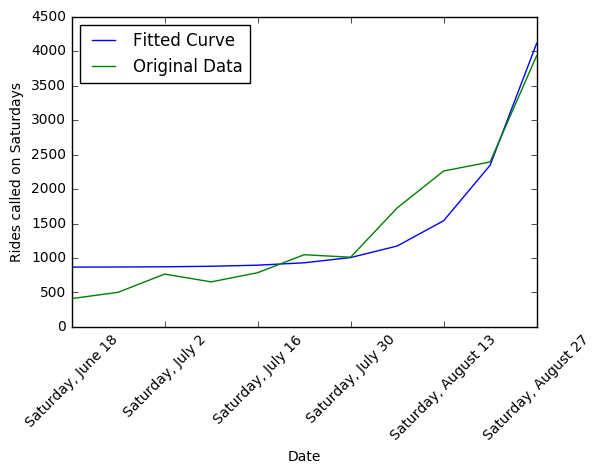

In [89]:
# So let's overlay it on the original data.
def fittedFunc(x):
    return 867.18954071+1.11885051**x
plt.plot(fittedFunc(daily), label='Fitted Curve')
Saturdays.plot(label="Original Data")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Saturdays')
plt.show()
plt.show()
plt.close()

This is pretty satisfying as a fit. We can see that presently the RideAustin Saturday schedule is undergoing a good fit with the exponential growth curve. However, the curve seems like it might be improved with a positive linear growth, so let's modify the function again:

[ 313.41539919   19.3553206     1.11282925]


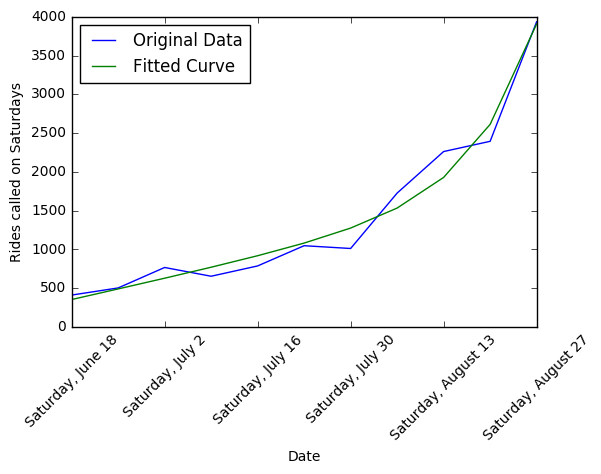

In [88]:
# Below is an exponential function with unknown coefficient and unknown y-intercept
def newFunction(x, a, b, c):
    return a + b*x + c**x 
newpopdaily, newpcovdaily = curve_fit(newFunction,daily,SaturdayArray) # x is the 'week' array, y is '
print(newpopdaily) 
#print(newpcovdaily)
def newFittedFunc(x):
    return 313.41539919+19.3553206*x + 1.11282925**x

Saturdays.plot(label="Original Data")
plt.plot(newFittedFunc(daily), label='Fitted Curve')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Saturdays')
plt.show()
plt.close()

This gives us a very satisfying curve indeed! This appears to predict closely the rate of increased adoption on Saturdays, and suggests a baseline initial adoption of 313 rides on a Saturday, increasing linearly about 20 rides per day and then exponentially up about 11% (1.112) every successive day. It might be better to have a weekly figure for those rates of increase, so we can do the same curve fit against the Saturday data considered weekly:

[ 236.35357718  127.66502375    2.017996  ]
[  411.   503.   767.   654.   787.  1048.  1012.  1727.  2263.  2395.
  3937.]


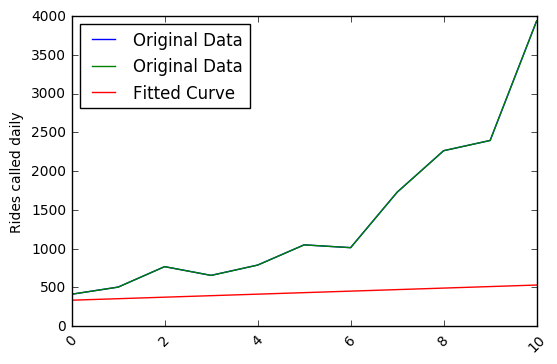

In [92]:
newFuncpopw, newFuncpcovw = curve_fit(newFunction,weekly,SaturdayArray)
print(newFuncpopw)
print(SaturdayArray)

plt.plot(SaturdayArray, label="Original Data")
plt.plot(newFittedFunc(weekly), label='Fitted Curve')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called daily')
plt.show()
plt.close()

This one's plotting kind of funny, so I think it needs work before final delivery.

In [86]:
#print(Saturdays)

Date
Saturday, June 18       411
Saturday, June 25       503
Saturday, July 2        767
Saturday, July 9        654
Saturday, July 16       787
Saturday, July 23      1048
Saturday, July 30      1012
Saturday, August 6     1727
Saturday, August 13    2263
Saturday, August 20    2395
Saturday, August 27    3937
Name: Rides, dtype: int64
